## Import Modules

In [1]:
#EDA notebook
#Feature selection notebook
#Modeling Testing Notebook
#Final Modeling Notebook

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
np.random.seed(42)

## Read in CSV Files

In [3]:
train = pd.read_csv('./data/train.csv')
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


# Clean Train Data

## Remove Spaces in Column Titles

In [5]:
train.columns = train.columns.str.replace(' ', '')

## Drop Columns [Id, PID, SalePrice]

In [6]:
train.drop(['Id', 'PID'], axis=1, inplace=True)

## Change Type for Columns

**Convert 'MSSubclass' and 'Yr Sold' to Categorical**

In [7]:
train['MSSubClass'] = train['MSSubClass'].astype(object)
train['YrSold'] = train['YrSold'].astype(object)

## Null Values

In [8]:
train.isnull().sum()[train.isnull().sum() > 0].sort_values(ascending=False)

PoolQC          2042
MiscFeature     1986
Alley           1911
Fence           1651
FireplaceQu     1000
LotFrontage      330
GarageYrBlt      114
GarageCond       114
GarageQual       114
GarageFinish     114
GarageType       113
BsmtExposure      58
BsmtFinType2      56
BsmtCond          55
BsmtQual          55
BsmtFinType1      55
MasVnrType        22
MasVnrArea        22
BsmtHalfBath       2
BsmtFullBath       2
GarageCars         1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
GarageArea         1
TotalBsmtSF        1
dtype: int64

**Categorical Columns**

I replaced all of the Null values in the categorical columns with the string 'None.'

In [9]:
categorical_null_cols = ['MiscFeature', 'Alley', 'Fence',
 'FireplaceQu','GarageQual', 'GarageCond',
 'GarageFinish','GarageType', 'BsmtExposure',
 'BsmtFinType2', 'BsmtCond', 'BsmtQual',
 'BsmtFinType1', 'MasVnrType']

In [10]:
for col in train.columns:
    if col in categorical_null_cols:
        train[col].fillna(value = 'None', inplace=True)

**Numeric Columns **

In the numeric columns with discrete values I replaced the Null values with 0.  In the numeric columns with contonuous values I replaced the Null values with the median value from the respective column.

In [11]:
numeric_null_cols = ['BsmtHalfBath',
 'BsmtFullBath','GarageCars']

In [12]:
numeric_median_cols = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
           'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF']

In [13]:
for col in train.columns:
    if col in numeric_null_cols:
        train[col].fillna(value = 0, inplace=True)

In [14]:
for col in train.columns:
    if col in numeric_median_cols:
        train[col].fillna(value = train[col].median(), inplace=True)

1564 of non null GarageYrBlt values match YearBuilt, whilst it is not over 90% of the values, we can assume that for the vast majority of the cases, YearBuilt will be an accurate value to fill these missing values with.

In [15]:
counter = 0
for x in train[train['GarageYrBlt'].notnull()][['GarageYrBlt','YearBuilt']].values:
    if x[0] == x[1]:
        counter += 1
print(counter)

1564


In [16]:
train.loc[train['GarageYrBlt'].isnull(), 'GarageYrBlt'] = train[train['GarageYrBlt'].isnull()]['YearBuilt']

## Feature Engineering

**Removing Highly Correlated Columns (Multicollinearity)**

Add column that indicates whether or not house has been remodeled.

In [17]:
train.loc[train['YearBuilt'] != train['YearRemod/Add'], 'Remodeled'] = 'Remodeled'

In [18]:
train.loc[train['YearBuilt'] == train['YearRemod/Add'], 'Remodeled'] = 'Not Remodeled'

Remove columns that are redundant.  

In [19]:
columns_to_remove = []

columns_to_remove.append('GarageCars')
columns_to_remove.append('GarageYrBlt')

columns_to_remove.append('BsmtFinSF1')
columns_to_remove.append('BsmtFinSF2')
columns_to_remove.append('BsmtUnfSF')

columns_to_remove.append('1stFlrSF')
columns_to_remove.append('2ndFlrSF')
columns_to_remove.append('LowQualFinSF')



train.drop(columns_to_remove, axis=1, inplace=True)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 72 columns):
MSSubClass       2051 non-null object
MSZoning         2051 non-null object
LotFrontage      2051 non-null float64
LotArea          2051 non-null int64
Street           2051 non-null object
Alley            2051 non-null object
LotShape         2051 non-null object
LandContour      2051 non-null object
Utilities        2051 non-null object
LotConfig        2051 non-null object
LandSlope        2051 non-null object
Neighborhood     2051 non-null object
Condition1       2051 non-null object
Condition2       2051 non-null object
BldgType         2051 non-null object
HouseStyle       2051 non-null object
OverallQual      2051 non-null int64
OverallCond      2051 non-null int64
YearBuilt        2051 non-null int64
YearRemod/Add    2051 non-null int64
RoofStyle        2051 non-null object
RoofMatl         2051 non-null object
Exterior1st      2051 non-null object
Exterior2nd      2051 n

In [21]:
train['HouseStyle'].value_counts()

1Story    1059
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: HouseStyle, dtype: int64

## House Style and Mean Price

In [22]:
train[train['HouseStyle'] == '2Story']['SalePrice'].mean()

206408.96321070235

In [23]:
train[train['HouseStyle'] == '1.5Fin']['SalePrice'].mean()

136480.09174311926

In [24]:
train[train['HouseStyle'] == '1Story']['SalePrice'].mean()

179809.19452313503

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [147]:
PCA_X = numeric_columns.drop('SalePrice', axis=1)

In [148]:
PCA_y = numeric_columns['SalePrice']

In [150]:
ss = StandardScaler()
PCA_sc = ss.fit_transform(PCA_X)

In [151]:
pca = PCA(n_components=15)

In [155]:
PCA_transform = pca.fit_transform(X=PCA_sc, y=PCA_y)

In [159]:
lr = LinearRegression()

In [160]:
PCA_X_train, PCA_X_test, PCA_y_train, PCA_y_test = train_test_split(PCA_sc, PCA_y, test_size=.3, random_state=42)

In [161]:
lr.fit(PCA_X_train, PCA_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [162]:
PCA_predict = lr.predict(PCA_X_test)

In [164]:
lr.score(PCA_X_test, PCA_y_test)

-8.1488672445408186e+22

In [169]:
np.sqrt(mean_squared_error(PCA_y_test, PCA_predict))

23072056689458284.0

## Plot

In [180]:
betas = pd.DataFrame(lasso.coef_, columns=list(X_train.columns)).T

ValueError: Shape of passed values is (1, 313), indices imply (313, 313)

In [178]:
lr.coef_

array([  2.31081505e+03,   4.33669920e+03,   7.40473307e+03,
         6.19397215e+03,   1.26324256e+04,   1.98403257e+03,
         4.30336804e+03,   1.07718875e+04,   2.69815437e+04,
         4.11626531e+03,   3.54418551e+02,   1.75825605e+03,
         1.51696436e+03,  -3.61988017e+03,  -1.07302839e+03,
         6.27244503e+02,   3.75599589e+03,   6.03838767e+03,
         1.39674708e+03,  -8.72353430e+01,  -2.72073347e+02,
        -5.36233324e+02,   3.41132700e+03,  -8.84863618e+03,
         4.01782143e+03,  -4.17982073e+02,   3.42506618e+15,
         1.52649552e+15,   3.12750306e+14,   5.17746687e+14,
         2.08837313e+15,   2.78867165e+15,   1.45188263e+15,
         6.23657286e+14,   1.41278131e+15,   8.22575321e+14,
         2.78779241e+15,   1.73930780e+15,   1.56490149e+14,
         1.43639489e+15,   5.17746687e+14,   1.04960788e+15,
        -1.11412982e+15,   1.25884601e+15,   2.84299340e+15,
        -7.27207736e+15,   1.08192111e+15,   5.43939196e+15,
         4.73606548e+15,

## Heatmap for Numeric Columns

In [131]:
numeric_columns = train[train.select_dtypes(exclude = object).columns]
len(list(numeric_columns)), type(numeric_columns)

(314, pandas.core.frame.DataFrame)

In [26]:
corr = numeric_columns.corr()

In [27]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

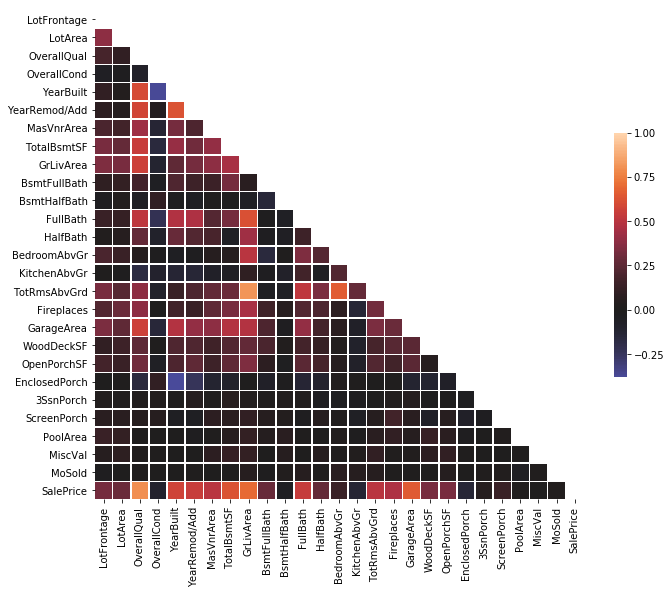

In [28]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Correlation Matrix for Numeric Columns

In [19]:
c = train.corr().abs().unstack().sort_values(ascending=False)
c[(c >= 0.5) | (c <= 1)]

SalePrice        SalePrice          1.000000
Bsmt Full Bath   Bsmt Full Bath     1.000000
Half Bath        Half Bath          1.000000
Bedroom AbvGr    Bedroom AbvGr      1.000000
Kitchen AbvGr    Kitchen AbvGr      1.000000
TotRms AbvGrd    TotRms AbvGrd      1.000000
Fireplaces       Fireplaces         1.000000
Garage Yr Blt    Garage Yr Blt      1.000000
Garage Cars      Garage Cars        1.000000
Garage Area      Garage Area        1.000000
Wood Deck SF     Wood Deck SF       1.000000
Open Porch SF    Open Porch SF      1.000000
Enclosed Porch   Enclosed Porch     1.000000
3Ssn Porch       3Ssn Porch         1.000000
Screen Porch     Screen Porch       1.000000
Pool Area        Pool Area          1.000000
Misc Val         Misc Val           1.000000
Full Bath        Full Bath          1.000000
Gr Liv Area      Gr Liv Area        1.000000
Yr Sold          Yr Sold            1.000000
Low Qual Fin SF  Low Qual Fin SF    1.000000
PID              PID                1.000000
MS SubClas

In [14]:
train_corr = train.corr().sort_values('SalePrice', ascending=False)
train_corr

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
SalePrice,-0.051398,-0.255052,-0.087335,0.341842,0.296566,0.800207,-0.097019,0.571849,0.550370,0.512230,0.423519,0.016255,0.190210,0.628925,0.618486,0.248452,-0.041594,0.697038,0.283662,-0.045328,0.537969,0.283001,0.137067,-0.125444,0.504014,0.471093,0.533922,0.648220,0.650270,0.326490,0.333476,-0.135656,0.048732,0.134581,0.023106,-0.007375,0.032735,-0.015203,1.000000
Overall Qual,-0.061483,-0.265863,0.035763,0.194808,0.105824,1.000000,-0.082770,0.602964,0.584654,0.438685,0.278742,-0.028199,0.275773,0.548742,0.477136,0.228152,-0.052338,0.566701,0.175171,-0.047318,0.515080,0.274859,0.053373,-0.170964,0.382025,0.388920,0.574553,0.587423,0.563814,0.257081,0.308855,-0.154554,0.031938,0.048752,0.006558,0.022099,0.019242,-0.011578,0.800207
Gr Liv Area,-0.023881,-0.112936,0.068210,0.383856,0.327427,0.566701,-0.109804,0.258838,0.322407,0.387833,0.215295,0.001083,0.234618,0.453635,0.562441,0.639092,0.106266,1.000000,0.066085,-0.054408,0.617323,0.429707,0.507579,0.097027,0.813333,0.458701,0.286279,0.486600,0.490949,0.270239,0.345008,-0.007777,0.024504,0.101926,0.113034,0.113673,0.049644,-0.015891,0.697038
Garage Area,-0.045201,-0.200891,-0.108228,0.358457,0.263296,0.563814,-0.137917,0.487177,0.398999,0.384718,0.331611,0.013190,0.145080,0.488805,0.498712,0.121286,-0.071190,0.490949,0.204717,-0.024987,0.398261,0.177438,0.069940,-0.068536,0.341143,0.291655,0.552069,0.893180,1.000000,0.245513,0.247222,-0.112353,0.043918,0.071067,0.045876,0.033641,0.009964,-0.003589,0.650270
Garage Cars,-0.048666,-0.228368,-0.049148,0.297143,0.214954,0.587423,-0.168513,0.542544,0.441796,0.361211,0.260676,-0.002129,0.167905,0.432979,0.438981,0.172997,-0.080990,0.486600,0.172903,-0.032965,0.467490,0.231874,0.085918,-0.034496,0.368034,0.310687,0.579623,1.000000,0.893180,0.240721,0.215364,-0.139608,0.028393,0.053582,0.021566,0.003053,0.020801,-0.009996,0.648220
Total Bsmt SF,-0.038346,-0.203795,-0.226038,0.356584,0.277175,0.548742,-0.158643,0.410254,0.308545,0.408575,0.538999,0.086545,0.419238,1.000000,0.808756,-0.217351,-0.022449,0.453635,0.321372,0.005404,0.325598,-0.055104,0.049111,-0.050003,0.293567,0.333100,0.348384,0.432979,0.488805,0.224659,0.257227,-0.088055,0.060283,0.076061,0.061503,0.125600,0.003915,-0.004280,0.628925
1st Flr SF,-0.022650,-0.145862,-0.246212,0.463900,0.381593,0.477136,-0.150938,0.323315,0.244190,0.391349,0.462198,0.095675,0.302299,0.808756,1.000000,-0.268855,-0.010399,0.562441,0.269535,0.008695,0.367623,-0.112193,0.090768,0.073033,0.393254,0.394729,0.264124,0.438981,0.498712,0.226243,0.259072,-0.044032,0.066991,0.089140,0.129995,0.139496,0.027038,-0.007432,0.618486
Year Built,-0.064444,-0.347039,0.035983,0.109504,0.036002,0.602964,-0.370988,1.000000,0.629116,0.329741,0.275440,-0.021031,0.136662,0.410254,0.323315,0.022313,-0.159403,0.258838,0.215200,-0.031464,0.480169,0.283207,-0.042149,-0.127162,0.137783,0.168848,0.825316,0.542544,0.487177,0.216339,0.207798,-0.380082,0.016104,-0.037866,0.003728,0.000626,-0.007083,-0.003559,0.571849
Year Remod/Add,-0.090040,-0.176666,0.044836,0.085052,0.050771,0.584654,0.042614,0.629116,1.000000,0.211443,0.166680,-0.057163,0.160066,0.308545,0.244190,0.159605,-0.066577,0.322407,0.153507,-0.037923,0.471555,0.224106,-0.019748,-0.135926,0.202397,0.138858,0.674024,0.441796,0.398999,0.216271,0.264476,-0.237523,0.040416,-0.041211,-0.022382,-0.001704,0.011568,0.042744,0.550370
Full Bath,-0.059086,-0.179370,0.142087,0.152812,0.125601,0.515080,-0.219189,0.480169,0.471555,0.240034,0.074982,-0.074144,0.278633,0.325598,0.367623,0.383072,0.002586,0.617323,-0.01079

In [31]:
def highlight(val):
    return 'background-color: yellow' if val > 0.5 else 'black'

In [32]:
train_corr = train_corr.style.applymap(highlight)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
SalePrice,0.325129,0.296566,0.800207,-0.0970189,0.571849,0.55037,0.503579,0.628754,0.697038,0.283332,-0.0452903,0.537969,0.283001,0.137067,-0.125444,0.504014,0.471093,0.650241,0.32649,0.333476,-0.135656,0.0487319,0.134581,0.0231063,-0.00737476,0.0327354,1
OverallQual,0.182361,0.105824,1,-0.0827704,0.602964,0.584654,0.430041,0.548548,0.566701,0.175896,-0.047006,0.51508,0.274859,0.0533727,-0.170964,0.382025,0.38892,0.563719,0.257081,0.308855,-0.154554,0.0319377,0.0487522,0.00655824,0.0220987,0.0192424,0.800207
GrLivArea,0.349084,0.327427,0.566701,-0.109804,0.258838,0.322407,0.383875,0.453555,1,0.0643233,-0.0545227,0.617323,0.429707,0.507579,0.0970274,0.813333,0.458701,0.490907,0.270239,0.345008,-0.00777677,0.0245043,0.101926,0.113034,0.113673,0.0496443,0.697038
GarageArea,0.337745,0.263292,0.563719,-0.137906,0.486844,0.398961,0.380396,0.488738,0.490907,0.204621,-0.0249564,0.398214,0.177403,0.0699419,-0.0685383,0.341133,0.291581,1,0.245499,0.247181,-0.112033,0.0439162,0.0710614,0.0458746,0.0336395,0.00994371,0.650241
TotalBsmtSF,0.332511,0.277191,0.548548,-0.158666,0.410238,0.308457,0.403551,1,0.453555,0.321827,0.00570317,0.325582,-0.0550452,0.0491685,-0.0499877,0.293499,0.333093,0.488738,0.224679,0.257243,-0.0880252,0.06029,0.0760784,0.061507,0.125606,0.00396996,0.628754
YearBuilt,0.103534,0.0360023,0.602964,-0.370988,1,0.629116,0.32078,0.410238,0.258838,0.21559,-0.0312993,0.480169,0.283207,-0.042149,-0.127162,0.137783,0.168848,0.486844,0.216339,0.207798,-0.380082,0.0161044,-0.0378656,0.00372829,0.000625828,-0.00708309,0.571849
YearRemod/Add,0.0799094,0.0507713,0.584654,0.0426145,0.629116,1,0.204234,0.308457,0.322407,0.153771,-0.0377634,0.471555,0.224106,-0.0197479,-0.135926,0.202397,0.138858,0.398961,0.216271,0.264476,-0.237523,0.0404163,-0.0412107,-0.0223821,-0.00170428,0.011568,0.55037
FullBath,0.138012,0.125601,0.51508,-0.219189,0.480169,0.471555,0.232474,0.325582,0.617323,-0.0113804,-0.0601713,1,0.153656,0.344123,0.165939,0.51963,0.218833,0.398214,0.175502,0.244452,-0.125383,0.0278699,-0.0142957,0.0104583,0.00329273,0.0493902,0.537969
TotRmsAbvGrd,0.331864,0.238724,0.382025,-0.0935761,0.137783,0.202397,0.271657,0.293499,0.813333,-0.0399857,-0.0542624,0.51963,0.339638,0.655439,0.276663,1,0.311765,0.341133,0.182835,0.226346,0.00552058,-0.00810113,0.0463288,0.0724998,0.100175,0.0541542,0.504014
MasVnrArea,0.197858,0.16752,0.430041,-0.131908,0.32078,0.204234,1,0.403551,0.383875,0.147129,0.0118847,0.232474,0.186871,0.0547862,-0.0702549,0.271657,0.265911,0.380396,0.164006,0.157836,-0.105934,0.0117712,0.0882074,0.0127892,0.07963,-0.00391545,0.503579


## Correlations with Sale Price

Text(0.5,1,'Correlations with Sale Price')

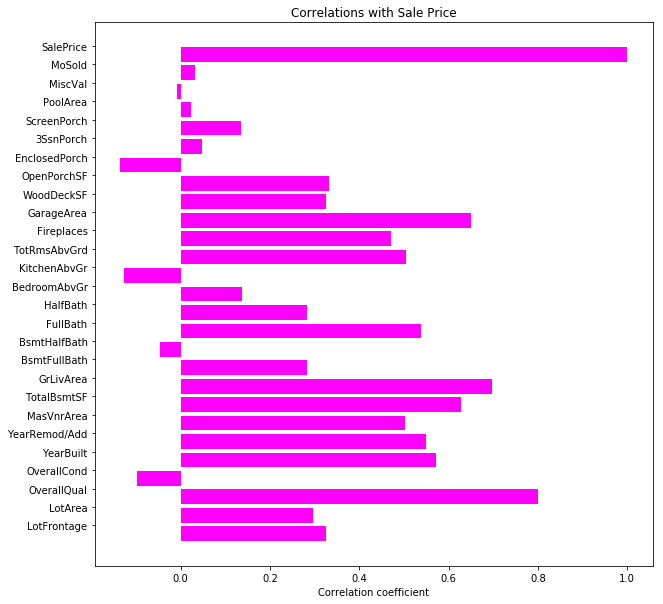

In [33]:
# num_feat=house.columns[house.dtypes!=object]
# num_feat=num_feat[1:-2] 
labels = []
values = []
for col in numeric_columns:
    labels.append(col)
    values.append(np.corrcoef(train[col].values, train.SalePrice.values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(10,10))
rects = ax.barh(ind, np.array(values), color='magenta')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlations with Sale Price")

## Scatterplots for Numeric Columns

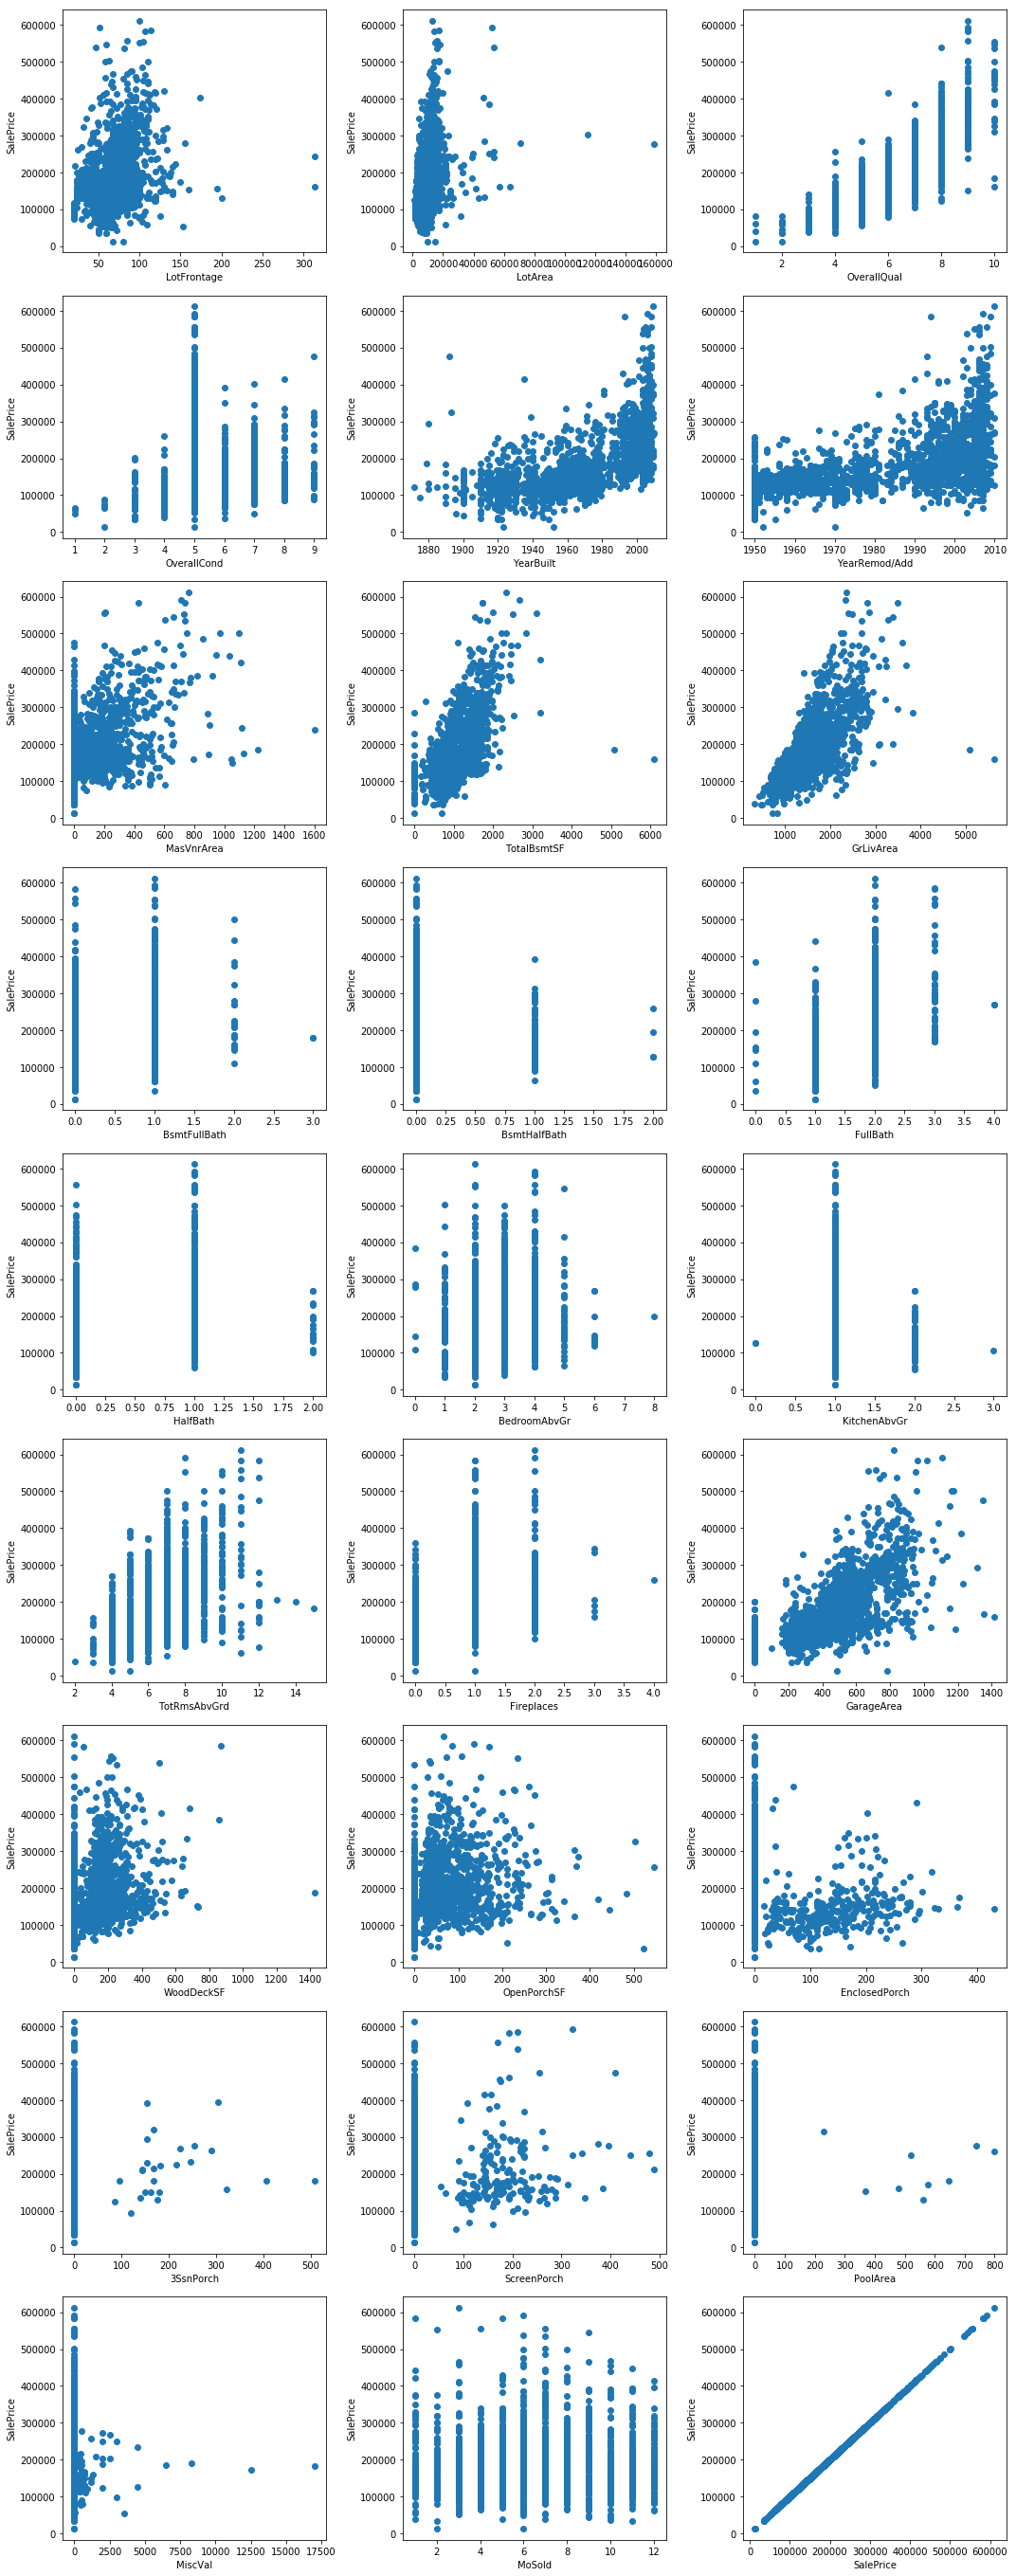

In [34]:
fig = plt.figure(figsize=(15,50))
for i, col in enumerate(numeric_columns):
    fig.add_subplot(12,3,1+i)
    plt.scatter(train[col], train['SalePrice'])
    plt.xlabel(col)
    plt.ylabel('SalePrice')
fig.tight_layout()
fig.show()

fig.savefig('numeric_scatter.png');

## Outliers

Removing outliers.  

In [35]:
train = train.drop(train.index[[1628,183]])

In [36]:
train = train[train['LotFrontage'] < 300]

In [37]:
train = train[train['LotArea'] < 100000]

In [38]:
train = train[train['TotalBsmtSF'] < 5000]

In [39]:
train = train[train['GrLivArea'] < 5000]

In [40]:
train = train[train['WoodDeckSF'] < 1400]

## Create Dummies

In [41]:
train = pd.get_dummies(train)

In [42]:
train.shape

(2043, 314)

## Instantiate the model

In [43]:
lr = LinearRegression()

## Set Up X and Y

In [44]:
y = train['SalePrice']
X = train[[col for col in train.columns if col != 'SalePrice']]

In [45]:
y.head()

0    130500
1    220000
2    109000
3    174000
4    138500
Name: SalePrice, dtype: int64

## Create Train/Test Split and Scale Data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

## Scale the Data

In [47]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Feature Selection

### SelectKBest

In [48]:
# kbest = SelectKBest(100)

In [49]:
# X_train_sc_k100 = kbest.fit.transform(X_train_sc)

In [50]:
# X_test_sc_k100 = kbest.transform(X_test_sc)

### Lasso CV

In [51]:
# lasso_cv_k100 = LassoCV(alphas=np.logspace(-3,3,7), cv=5)

In [52]:
# lasso_cv_k100.fit(X_train_sc_k100, y_train)

In [53]:
# lasso_cv_k100.score(X_train_scx_k100, y_train)

In [54]:
# lasso_cv_k100.score(X_test_sc_k100, y_test)

In [55]:
#lasso_cv_k100.coef_

In [56]:
#lasso_cv_k100.intercept_

In [57]:
#lasso_cv_k100.alpha_

In [58]:
#pd.DataFrame(lasso.coef_, columns=X.columns)

In [59]:
#df = pd.DataFrame(lasso.coef_, index=X.columns[kbest_get_support()]).T

In [60]:
#df.columns = ['weights']

In [61]:
# df[df['weights'] == 0]

In [62]:
# return heatmap with variables with high correlation (df[['gr-live-area, ...]]).corr()

In [63]:
kf = KFold(n_splits=10, shuffle=True, random_state = 42)

In [64]:
train_scores = cross_val_score(lr, X_train, y_train, cv=kf)
print(train_scores), print(train_scores.mean());

[ 0.9092115   0.91433733  0.91381895  0.93270625  0.88742681  0.83437928
  0.92013319  0.92209101  0.87527989  0.90559563]
0.901497984397


In [65]:
test_scores = cross_val_score(lr, X_test, y_test, cv=kf)
print(test_scores), print(test_scores.mean());

[ 0.84470987  0.84316582  0.89562881  0.86239817  0.85988304  0.88324087
  0.86177576  0.84317269  0.89655298  0.89886932]
0.868939733883


## Modeling

## Fit the model

In [66]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
X_train.shape

(1430, 313)

In [68]:
lr.score(X_train, y_train)

0.94605715349150354

In [69]:
lr.score(X_test, y_test)

0.90114792305859293

In [70]:
mean_squared_error(y_train, lr.predict(X_train)) ** 0.5, mean_squared_error(y_test, lr.predict(X_test)) ** 0.5

(18207.940790389788, 25411.516767143836)

## Align columns with the $\beta$ coefficients

In [71]:
lr.coef_

array([  1.16515663e+02,   8.29086405e-01,   5.23635889e+03,
         5.61507014e+03,   4.18388441e+02,   9.45929924e+01,
         2.50216723e+01,   2.53033750e+01,   5.55806228e+01,
         7.91197802e+03,   1.40474923e+03,   3.18954817e+03,
         3.01784456e+03,  -4.36837513e+03,  -5.11441104e+03,
         4.04551491e+02,   5.91899113e+03,   2.81517253e+01,
         1.11997709e+01,  -1.31524053e+00,  -4.44894336e+00,
        -2.12745315e+01,   5.94491470e+01,  -2.43685999e+02,
         9.25549838e+00,  -1.53009583e+02,   7.78242845e+03,
         1.95172265e+04,   3.04203011e+04,   3.79729281e+04,
         1.98304080e+04,   4.56365319e+03,   1.65100094e+04,
         1.29125830e+04,  -4.19178230e+03,  -4.66134407e+03,
        -6.67211843e+03,  -1.53711469e+04,  -6.77395287e+04,
        -1.40163989e+04,  -3.41415382e+04,  -2.71568035e+03,
        -3.35377359e+03,  -1.46253994e+04,   1.11586853e+04,
         2.35741027e-09,   1.07987104e+04,   2.14043603e+03,
        -6.11865876e+03,

In [72]:
lr.intercept_

-1091483.5093845536

## Raw/Scaled Score

In [73]:
results = list()

In [74]:
raw_train_score = lr.score(X_train, y_train)
raw_test_score = lr.score(X_test, y_test)

results.append({'name':'raw',
                'model': 'no model',
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_train_score})

results.append({'name':'raw',
                'model':'no model',
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_test_score})

In [75]:
scaled_train_score = lr.score(X_train_sc, y_train)
scaled_test_score = lr.score(X_test_sc, y_test)

results.append({'name':'scaled',
                'model': 'no model',
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_train_score})

results.append({'name':'scaled',
                'model':'no model',
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_test_score})

## Regularization

In [76]:
ridge = Ridge()
lasso = Lasso()
enet = ElasticNet()

In [77]:
ridge_fit = ridge.fit(X_train_sc, y_train)
lasso_fit = lasso.fit(X_train_sc, y_train)
enet_fit = enet.fit(X_train_sc, y_train)

In [78]:
train_ridge_score = ridge.score(X_train_sc, y_train)
test_ridge_score = ridge.score(X_test_sc, y_test)
train_lasso_score = lasso.score(X_train_sc, y_train)
test_lasso_score = lasso.score(X_test_sc, y_test)
train_enet_score = enet.score(X_train_sc, y_train)
test_enet_score = enet.score(X_test_sc, y_test)

In [79]:
results.append({'name': 'ridge',
                'model': ridge_fit,
                'dataset': 'train',
                'preprocessing': 'scaled',
                'score': train_ridge_score})

results.append({'name': 'ridge',
                'model': ridge_fit,
                'dataset': 'test',
                'preprocessing': 'scaled',
                'score': test_ridge_score})

results.append({'name': 'lasso',
                'model': lasso_fit,
                'dataset': 'train',
                'preprocessing': 'scaled',
                'score': train_lasso_score})

results.append({'name': 'lasso',
                'model': lasso_fit,
                'dataset': 'test',
                'preprocessing': 'scaled',
                'score': test_lasso_score})

results.append({'name': 'elastic net',
                'model': enet,
                'dataset': 'train',
                'preprocessing': 'scaled',
                'score': train_enet_score})

results.append({'name': 'elastic net',
                'model': enet,
                'dataset': 'test',
                'preprocessing': 'scaled',
                'score': test_enet_score})

In [80]:
results_df = pd.DataFrame(results)
results_df

,dataset,model,name,preprocessing,score
0,train,no model,raw,raw,0.946057
1,test,no model,raw,raw,0.901148
2,train,no model,scaled,scaled,-275.687735
3,test,no model,scaled,scaled,-257.604415
4,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,scaled,0.946055
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,scaled,0.901371
6,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,scaled,0.946057
7,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,scaled,0.902827
8,train,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",elastic net,scaled,0.928146
9,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",elastic net,scaled,0.903633


## Interpreting Model Coefficients

In [81]:
list(zip(X.columns, lr.coef_))

[('LotFrontage', 116.51566306600489),
 ('LotArea', 0.82908640520281018),
 ('OverallQual', 5236.3588900543245),
 ('OverallCond', 5615.0701418197432),
 ('YearBuilt', 418.38844122506083),
 ('YearRemod/Add', 94.592992393901227),
 ('MasVnrArea', 25.021672295053548),
 ('TotalBsmtSF', 25.303375007064915),
 ('GrLivArea', 55.580622841330182),
 ('BsmtFullBath', 7911.9780174877696),
 ('BsmtHalfBath', 1404.7492296357857),
 ('FullBath', 3189.5481708380944),
 ('HalfBath', 3017.8445643301116),
 ('BedroomAbvGr', -4368.3751321867167),
 ('KitchenAbvGr', -5114.4110406434547),
 ('TotRmsAbvGrd', 404.55149115405163),
 ('Fireplaces', 5918.9911339791706),
 ('GarageArea', 28.15172532795259),
 ('WoodDeckSF', 11.199770879675498),
 ('OpenPorchSF', -1.3152405265169591),
 ('EnclosedPorch', -4.4489433636874764),
 ('3SsnPorch', -21.274531458587717),
 ('ScreenPorch', 59.449147005152611),
 ('PoolArea', -243.68599875160839),
 ('MiscVal', 9.2554983825539239),
 ('MoSold', -153.00958323032739),
 ('MSSubClass_20', 7782.4284

**END**

## Clean Test Data

In [84]:
test = pd.read_csv('./data/test.csv', index_col=0)

In [85]:
test.shape

(879, 79)

## Remove Spaces in Column Titles

In [86]:
test.columns = test.columns.str.replace(' ', '')

# Drop Columns

In [85]:
test.drop(['Id', 'PID'], axis=1, inplace=True)

KeyError: "['Id'] not found in axis"

## Change Type for Columns

In [87]:
test['MSSubClass'] = test['MSSubClass'].astype(object)
test['YrSold'] = test['YrSold'].astype(object)

## Null Values

In [88]:
categorical_null_cols = ['MiscFeature', 'Alley', 'Fence',
 'FireplaceQu','GarageQual', 'GarageCond',
 'GarageFinish','GarageType', 'BsmtExposure',
 'BsmtFinType2', 'BsmtCond', 'BsmtQual',
 'BsmtFinType1', 'MasVnrType']

for col in test.columns:
    if col in categorical_null_cols:
        test[col].fillna(value = 'None', inplace=True)

numeric_null_cols = ['BsmtHalfBath',
 'BsmtFullBath','GarageCars']

numeric_median_cols = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
           'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF']

for col in test.columns:
    if col in numeric_null_cols:
        test[col].fillna(value = 0, inplace=True)

for col in test.columns:
    if col in numeric_median_cols:
        test[col].fillna(value = test[col].median(), inplace=True)

counter = 0
for x in test[test['GarageYrBlt'].notnull()][['GarageYrBlt','YearBuilt']].values:
    if x[0] == x[1]:
        counter += 1
print(counter)

test.loc[test['GarageYrBlt'].isnull(), 'GarageYrBlt'] = test[test['GarageYrBlt'].isnull()]['YearBuilt']

663


## Feature Engineering

In [89]:
test.loc[test['YearBuilt'] != test['YearRemod/Add'], 'Remodeled'] = 'Remodeled'

test.loc[test['YearBuilt'] == test['YearRemod/Add'], 'Remodeled'] = 'Not Remodeled'

columns_to_remove = []

columns_to_remove.append('GarageCars')
columns_to_remove.append('GarageYrBlt')

columns_to_remove.append('BsmtFinSF1')
columns_to_remove.append('BsmtFinSF2')
columns_to_remove.append('BsmtUnfSF')

columns_to_remove.append('1stFlrSF')
columns_to_remove.append('2ndFlrSF')
columns_to_remove.append('LowQualFinSF')



test.drop(columns_to_remove, axis=1, inplace=True)

## Outliers

In [90]:
# test = test[test['LotFrontage'] < 300]

# test = test[test['LotArea'] < 100000]

# test = test[test['TotalBsmtSF'] < 5000]

# test = test[test['GrLivArea'] < 5000]

# test = test[test['WoodDeckSF'] < 1400]

In [91]:
test.shape

(879, 72)

## Create Dummies

In [92]:
test = pd.get_dummies(test)

test.shape

(879, 297)

# Make Sure Train and Test Data Have Same Number/Order of Columns 

In [93]:
list(set(X_train.columns).difference(test.columns))

['Condition2_Artery',
 'MSSubClass_150',
 'Utilities_NoSeWa',
 'PoolQC_Fa',
 'Condition2_RRAe',
 'RoofMatl_Membran',
 'Electrical_Mix',
 'Neighborhood_Landmrk',
 'HeatingQC_Po',
 'Condition2_RRAn',
 'MSZoning_A (agr)',
 'BsmtCond_Ex',
 'GarageQual_Ex',
 'Exterior2nd_Stone',
 'Exterior1st_Stone',
 'Neighborhood_GrnHill',
 'Heating_Wall',
 'PoolQC_Gd',
 'BsmtCond_Po',
 'MiscFeature_TenC',
 'Functional_Sev',
 'Exterior1st_ImStucc',
 'Condition2_RRNn',
 'Functional_Sal',
 'Exterior1st_CBlock',
 'Heating_OthW']

In [94]:
list(set(test.columns).difference(X_train.columns))

['KitchenQual_Po',
 'Exterior1st_PreCast',
 'Exterior2nd_PreCast',
 'RoofMatl_Metal',
 'SaleType_VWD',
 'PID',
 'RoofMatl_Roll',
 'Exterior2nd_Other',
 'Heating_Floor',
 'MasVnrType_CBlock']

**Drop Rows from Test Data**

In [95]:
test = test.drop(columns=[
    'SaleType_VWD',
    'Heating_Floor',
    'MasVnrType_CBlock',
    'RoofMatl_Roll',
    'Exterior2nd_Other',
    'Exterior1st_PreCast',
    'KitchenQual_Po',
    'RoofMatl_Metal',
    'Exterior2nd_PreCast'])

**Add Columns to Test**

In [96]:
test['Heating_Wall'] = 0
test['PoolQC_Gd'] = 0
test['Functional_Sev'] = 0
test['Exterior1st_Stone'] = 0
test['MSZoning_A (agr)'] = 0
test['Utilities_NoSeWa'] = 0
test['Heating_OthW'] = 0
test['Exterior2nd_Stone'] = 0
test['Condition2_RRNn'] = 0
test['Condition2_RRAe'] = 0
test['Exterior1st_ImStucc'] = 0
test['BsmtCond_Ex'] = 0
test['Neighborhood_Landmrk'] = 0
test['Electrical_Mix'] = 0
test['MiscFeature_TenC'] = 0
test['RoofMatl_Membran'] = 0
test['Neighborhood_GrnHill'] = 0
test['BsmtCond_Po'] = 0
test['Exterior1st_CBlock'] = 0
test['HeatingQC_Po'] = 0
test['MSSubClass_150'] = 0
test['PoolQC_Fa'] = 0
test['Condition2_RRAn'] = 0
test['Condition2_Artery'] = 0
test['GarageQual_Ex'] = 0
test['Functional_Sal'] = 0

**Add Columns to Train**

In [97]:
X_train.shape

(1430, 313)

In [98]:
test.shape

(879, 314)

In [99]:
set(test.columns) == set(X_train.columns)

False

In [100]:
X_train.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea',
       'BsmtFullBath',
       ...
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD ',
       'Remodeled_Not Remodeled', 'Remodeled_Remodeled'],
      dtype='object', length=313)

In [101]:
X_train.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea',
       'BsmtFullBath',
       ...
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD ',
       'Remodeled_Not Remodeled', 'Remodeled_Remodeled'],
      dtype='object', length=313)

In [102]:
test.columns

Index(['PID', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemod/Add', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea',
       ...
       'Neighborhood_GrnHill', 'BsmtCond_Po', 'Exterior1st_CBlock',
       'HeatingQC_Po', 'MSSubClass_150', 'PoolQC_Fa', 'Condition2_RRAn',
       'Condition2_Artery', 'GarageQual_Ex', 'Functional_Sal'],
      dtype='object', length=314)

In [103]:
test = test[X_train.columns]

## Load kaggle data

In [104]:
len(lr.coef_)

313

In [105]:
preds = lr.predict(test)

In [106]:
submission = pd.DataFrame(preds, index=test.index, columns=['SalePrice'])

In [107]:
submission.sort_index(inplace=True)

## Create DataFrame With ID and SalePrice Predictions

In [115]:
final_prediction = lasso.predict(test)

In [116]:
train_set_predict = lasso.predict(X_test)

In [171]:
lasso.coef_

array([  2.35188210e+03,   4.54095440e+03,   7.42300849e+03,
         6.20687956e+03,   1.26649679e+04,   1.98965925e+03,
         4.27625678e+03,   1.08416239e+04,   2.64099219e+04,
         4.13118521e+03,   3.52796620e+02,   1.77788807e+03,
         1.49525189e+03,  -3.62067132e+03,  -1.10384175e+03,
         6.12571924e+02,   3.76633569e+03,   6.07636309e+03,
         1.39340690e+03,  -8.52213670e+01,  -2.67527725e+02,
        -5.13816359e+02,   3.54982664e+03,  -8.22049542e+03,
         3.24735764e+03,  -4.10135956e+02,   3.16038205e+03,
         3.99222045e+03,   1.32822465e+03,   1.91430312e+03,
         5.51046119e+03,   1.24834467e+03,   3.01104685e+03,
         1.04791047e+03,  -1.07160175e+03,  -6.78691709e+02,
        -2.91612130e+03,  -4.11207697e+03,  -1.81088848e+03,
        -2.99471961e+03,  -2.42618792e+03,  -5.74781426e+02,
        -3.22832018e+00,  -1.30341053e+03,   2.93448294e+03,
         0.00000000e+00,   1.17485708e+03,   1.79886701e+03,
        -1.40510468e+03,

In [118]:
np.sqrt(mean_squared_error(y_test, train_set_predict))

132798377.1507594

In [110]:
submission = pd.DataFrame(final_prediction, index=test.index, columns=['SalePrice'])

In [111]:
submission.shape

(879, 1)

In [112]:
submission.sort_index(inplace=True)

In [113]:
submission.to_csv('./data/lr_submission.csv')

In [ ]:
mean_squared_error(y_test, final_prediction)